In [19]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

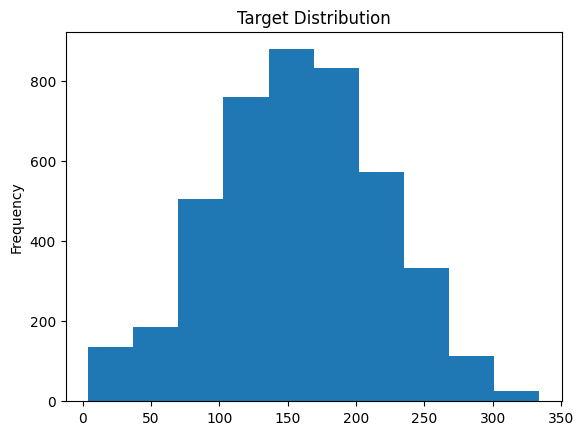

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [ ]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [ ]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [14]:
merged_df.shape

(4343, 184)

In [38]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []

for train_index, val_index in tqdm(kf.split(merged_df)):
    # Split the data
    train_X, val_X = merged_df.iloc[train_index], merged_df.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Train LightGBM
    model1 = lgb.LGBMRegressor( # feature_fraction=0.8, bagging_fraction=0.8,
        learning_rate=0.01, n_estimators=1000, random_state=42,
         metric='RMSE'
    )
    model1.fit(train_X, train_y, eval_set=[(val_X, val_y)])
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration_)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2 = weights
        combined_predictions = w1 * pred1 + w2 * pred2
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [0.5, 0.5]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = optimized_weights[0] * pred1 + optimized_weights[1] * pred2

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions) # np.mean((final_predictions - val_y) ** 2)
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.783948
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.558337
[LightGBM] [Debug] init for col-wise cost 0.000861 seconds, init for row-wise cost 0.001949 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.136730
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a 

1it [04:30, 270.13s/it]

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.783262
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.559493
[LightGBM] [Debug] init for col-wise cost 0.000970 seconds, init for row-wise cost 0.002225 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 157.271445
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a 

2it [07:34, 219.84s/it]

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.782508
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.558983
[LightGBM] [Debug] init for col-wise cost 0.004783 seconds, init for row-wise cost 0.001977 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 184
[LightGBM] [Info] Start training from score 156.375360
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a 

3it [10:27, 198.10s/it]

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.782305
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.560114
[LightGBM] [Debug] init for col-wise cost 0.000887 seconds, init for row-wise cost 0.001921 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.237122
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a 

4it [14:58, 227.08s/it]

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.782827
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.561365
[LightGBM] [Debug] init for col-wise cost 0.001777 seconds, init for row-wise cost 0.002014 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 184
[LightGBM] [Info] Start training from score 157.063309
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a 

5it [19:16, 231.34s/it]

Average MSE across folds: 37.18704965501804
Optimized weights per fold: [array([0.22984501, 0.77015499]), array([0.36415201, 0.63584799]), array([0., 1.]), array([0.27171709, 0.72828291]), array([0.11137537, 0.88862463])]


In [39]:
np.mean(optimized_weights_list, axis=0)

array([0.19541789, 0.80458211])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
final_model1 = lgb.LGBMRegressor(
    learning_rate=0.01, n_estimators=1000, random_state=42,
     metric='RMSE' # feature_fraction=0.8, bagging_fraction=0.8,
)
final_model1.fit(merged_df, y)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('dataset/LGBMCatBoostV2.4.csv', index=False)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.783320
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.559659
[LightGBM] [Debug] init for col-wise cost 0.001016 seconds, init for row-wise cost 0.009831 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 184
[LightGBM] [Info] Start training from score 157.016809
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a 

: 